In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
import os
from glob import glob
import random
import time
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

#our additions
import json
import sklearn

Using TensorFlow backend.


In [4]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10

def load_train():
    start_time = time.time()
    train_pose = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('..', 'sample_json', 'c' + str(classed), '*.json'))
        for file in files:
            jsonFile = open(file, 'r')
            try: 
                values = json.load(jsonFile)['people'][0]['pose_keypoints_2d']
            except IndexError: 
                continue
            #print(values)
            #print(len(values))
            train_pose.append(values)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_pose, train_labels 

In [5]:
train_pose, train_labels = load_train()
# train_labels            = np_utils.to_categorical(train_labels, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:00<00:03,  2.62it/s]

Loading directory c1


 20%|██        | 2/10 [00:00<00:02,  2.80it/s]

Loading directory c2


 30%|███       | 3/10 [00:01<00:02,  2.77it/s]

Loading directory c3


 40%|████      | 4/10 [00:01<00:02,  2.63it/s]

Loading directory c4


 50%|█████     | 5/10 [00:01<00:01,  2.69it/s]

Loading directory c5


 60%|██████    | 6/10 [00:02<00:01,  2.70it/s]

Loading directory c6


 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

Loading directory c7


 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

Loading directory c8


 90%|█████████ | 9/10 [00:03<00:00,  3.08it/s]

Loading directory c9


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Data Loaded in 3.434006929397583 second


In [6]:
print(len(train_pose))
print(len(train_labels))

22394
22394


In [423]:
#randomly assign train and validation sets 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(train_pose, train_labels, test_size= 0.2, random_state=42)

In [424]:
print((Y_train[:10]))

[5, 7, 3, 4, 2, 1, 2, 3, 0, 8]


In [425]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(75, 50)
        self.hidden2 = nn.Linear(50, 25)
        self.output = nn.Linear(25, 10)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.output(x)
        return x


In [426]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(75, 150)
        self.hidden2 = nn.Linear(150, 100)
        self.hidden3 = nn.Linear(100, 30)
        self.output = nn.Linear(30, 10)
        self.sigmoid = nn.Sigmoid()
        self.tanh    = nn.Tanh() 
        
    def forward(self, x, cnn_data):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.tanh(x)
        x = self.hidden3(x)
        x = F.tanh(x)
        x = np.concatenate((x, cnn_data), axis=1)
        x = np.hidden4(x)
        
        x = self.output(x)
        return x

In [434]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=.5)

In [435]:
#test variable batch size
batch_size = 50
epochs = 300
track_loss = []
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    if epoch > 0 and epoch%40==0:
        if batch_size < 800:
            batch_size *= 2
        print("batch size:", batch_size)
    for i in range(0, len(X_train), batch_size):
        # get the inputs; data is a list of [inputs, labels]
        # print(i)
        inputs = torch.FloatTensor(X_train[i:i+batch_size])
        labels = torch.LongTensor(Y_train[i:i+batch_size])
        
        # print(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    track_loss.append(running_loss * batch_size / 1000)
    print('[Epoch: %d] loss: %.3f' % (epoch + 1, running_loss * batch_size / 1000))
    

print('Finished Training')

[Epoch: 1] loss: 41.193
[Epoch: 2] loss: 40.841
[Epoch: 3] loss: 40.501
[Epoch: 4] loss: 40.110
[Epoch: 5] loss: 39.549
[Epoch: 6] loss: 38.738
[Epoch: 7] loss: 37.520
[Epoch: 8] loss: 35.887
[Epoch: 9] loss: 34.126
[Epoch: 10] loss: 32.552
[Epoch: 11] loss: 31.257
[Epoch: 12] loss: 30.198
[Epoch: 13] loss: 29.322
[Epoch: 14] loss: 28.544
[Epoch: 15] loss: 27.792
[Epoch: 16] loss: 27.082
[Epoch: 17] loss: 26.336
[Epoch: 18] loss: 25.595
[Epoch: 19] loss: 24.766
[Epoch: 20] loss: 23.894
[Epoch: 21] loss: 23.028
[Epoch: 22] loss: 22.175
[Epoch: 23] loss: 21.309
[Epoch: 24] loss: 20.590
[Epoch: 25] loss: 20.004
[Epoch: 26] loss: 19.452
[Epoch: 27] loss: 18.918
[Epoch: 28] loss: 18.502
[Epoch: 29] loss: 18.120
[Epoch: 30] loss: 17.823
[Epoch: 31] loss: 17.383
[Epoch: 32] loss: 16.962
[Epoch: 33] loss: 16.678
[Epoch: 34] loss: 16.392
[Epoch: 35] loss: 16.021
[Epoch: 36] loss: 15.710
[Epoch: 37] loss: 15.411
[Epoch: 38] loss: 15.560
[Epoch: 39] loss: 15.474
[Epoch: 40] loss: 15.270
batch siz

Text(0.5, 1.0, 'Pose Training loss')

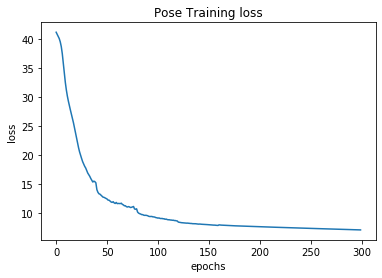

In [445]:
outputs = net(torch.FloatTensor(X_test))
_, predicted = torch.max(outputs, 1)
track_loss
x = [i for i in range(epochs)]
plt.plot(x, track_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Pose Training loss")

In [440]:
classes = ('Safe driving', 'Texting - right', 'Talking on the phone - right', 'Texting - left',
           'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching Behind', 'Hair and makeup', 'Talking to Passenger')
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:  Drinking Reaching Behind Safe driving Talking to Passenger Texting - left Drinking Safe driving Talking on the phone - right Reaching Behind Safe driving


In [441]:
count = 0
for i in range(len(Y_test)):
    if Y_test[i] == predicted[i]:
        count+=1
print(count/len(Y_test))


0.8803304308997544


In [442]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for i in range(len(Y_test)):
    label = Y_test[i]
    if Y_test[i] == predicted[i]:
        class_correct[label] += 1
    class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Safe driving : 92 %
Accuracy of Texting - right : 93 %
Accuracy of Talking on the phone - right : 90 %
Accuracy of Texting - left : 93 %
Accuracy of Talking on the phone - left : 91 %
Accuracy of Operating the radio : 97 %
Accuracy of Drinking : 81 %
Accuracy of Reaching Behind : 97 %
Accuracy of Hair and makeup : 57 %
Accuracy of Talking to Passenger : 79 %


In [443]:
sklearn.metrics.confusion_matrix(Y_test, predicted)

array([[427,   1,   1,  10,   1,   4,   0,   0,   2,  14],
       [  3, 471,   3,   0,   1,   1,  18,   1,   2,   2],
       [  0,   0, 443,   0,   0,   0,  15,   5,  24,   0],
       [  7,   0,   2, 446,  14,   2,   0,   1,   1,   5],
       [  4,   0,   0,  17, 396,   3,   0,   1,  13,   0],
       [  4,   1,   4,   3,   0, 433,   0,   0,   1,   0],
       [  0,  21,  23,   0,   0,   0, 363,   1,  36,   0],
       [  1,   2,   2,   0,   0,   1,   0, 409,   1,   2],
       [ 16,  13,  70,   1,  18,   0,  38,  15, 230,   2],
       [ 64,   5,   0,   3,   1,   5,   0,   3,   1, 325]])

In [11]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Son Do/.cache\torch\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:18<00:00, 7.09MB/s] 


In [18]:
for param in model.parameters():
    param.requires_grad = False
features = list(model.classifier.children())[:-1] # Remove last layer
model.classifier = nn.Sequential(*features)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
)

In [22]:
dataset = pd.read_csv('../input/driver_imgs_list.csv')
dataset.head(5)

FileNotFoundError: [Errno 2] File b'../input/driver_imgs_list.csv' does not exist: b'../input/driver_imgs_list.csv'